In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('PyTorch version:', torch.__version__)
print('PyTorch working with CUDA:', torch.cuda.is_available())

PyTorch version: 2.9.0+cu130
PyTorch working with CUDA: True


In [3]:
# Ordered list of data labels as per Fashion MNIST Documentation
data_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Data pre-processing transformations
transforms = Compose([
    ToTensor(), 
    Normalize(mean=0.5, std=0.5)
])

# Initialises data
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms
)

# Batch Size (default = 64)
batch_size = 64

# Load the data with automatic shuffling
train_loader = DataLoader(training_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)


train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Tests
train_expected_size = torch.Size([batch_size,1,28,28])
assert train_images.shape == train_expected_size

expected_label_size = torch.Size([batch_size])
assert train_labels.shape == expected_label_size

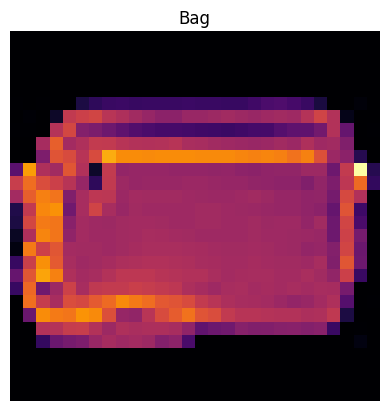

In [4]:
# Plot of random sample with label
img = train_images[0].squeeze()
label = data_labels[train_labels[0]]

fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.set_cmap('inferno')
plt.title(label)
plt.show()

In [5]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, hidden1,hidden2,hidden3,in_features=28*28, out_features=10,use_dropout=False):
        '''
        3-Layer MLP with specifiable hidden layer size
        Args:
            hidden1 (int): specify the number of neurons in layer 1
            hidden2 (int): specify the number of neurons in layer 2
            hidden3 (int): specify the number of neurons in layer 3
            in_features (int/optional): specify the number of inputs (size of flattened image = length * width)
            out_features (int/optional): specify the number of outputs (number of classes)
            use_dropout (bool/optional): enable dropout with p=0.2
        '''
        super().__init__()
        self.flatten = nn.Flatten()
        if use_dropout:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features,hidden1),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden2,hidden3),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden3, out_features),
            )
        else:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features,hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2,hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_features),
             )

    def forward(self, x):
        '''
        Perform a forward pass of the network.
        Note: This flattens the image for us so we need not reshape input data.
        Args:
            x (tensor): datapoint from our data
        '''
        x = self.flatten(x)
        output = self.lin_relu_stack(x)
        output = F.softmax(output, dim=1)
        return output

In [ ]:
# Initialise model and check structure
ann_model = MultilayerPerceptron(1536,768,256)
print(ann_model)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    '''
    Perform a simple training pass for one epoch
    Args:
        dataloader (Dataloader(data)): Dataloader using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function used
        optim: optimiser used for gradient parameter adjustment
    '''
    model.train()
    num_batch = len(dataloader)
    train_loss = 0
    for X,label in dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batch
    print(f'Training loss = {train_loss:>5f}')
    return train_loss

def test(dataloader, model,loss_fn):
    '''
    Perform a test pass.
    Args:
        dataloader (DataLoader(data)): Dataloader of a dataset using torchvision
        model (ANN/CNN): Chosen model
    '''
    model.eval()
    num_batch = len(dataloader)
    samples = len(dataloader.dataset)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X,label in dataloader:
            pred = model(X)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            pred = pred.argmax(1)
            correct += (pred == label).type(torch.float).sum().item()
    test_loss /= num_batch
    accuracy = correct/samples * 100
    print(f'Test loss = {test_loss:>5f} (Accuracy = {accuracy:.2f}%)')
    return test_loss, accuracy

In [8]:
# training/test loop
def run(train_loader,test_loader, model, epochs,loss_fn,optimizer):
    '''
    Runs our model train and test loop for a specified number of epochs
    Args:
    train_loader (Dataloader(data)): Training data
    test_loader (Dataloader(data)): Test data
    model (MultilayerPerceptron): Model
    epochs (int): Number of epochs
    '''
    loss_hist = []
    accuracy_hist = []
    for e in range(epochs):
        print(f'Epoch {e+1}/{epochs}')
        train_loss = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_accuracy = test(test_loader, model,loss_fn)
        loss_hist.append([train_loss,test_loss])
        accuracy_hist.append(test_accuracy)
    return loss_hist, accuracy_hist

In [9]:
# initial hyperparameters
learn_rate = 1e-3
epochs = 25

# initialise loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ann_model.parameters(), lr=learn_rate,momentum=0.9)

In [10]:
ann_hist, ann_accuracy = run(train_loader,test_loader,ann_model,epochs,loss_fn,optimizer)

Epoch 1/25
Training loss = 2.297457
Test loss = 2.289721 (Accuracy = 48.17%)
Epoch 2/25
Training loss = 2.243495
Test loss = 2.139627 (Accuracy = 33.08%)
Epoch 3/25
Training loss = 1.987848
Test loss = 1.858804 (Accuracy = 65.03%)
Epoch 4/25
Training loss = 1.797991
Test loss = 1.758657 (Accuracy = 73.78%)
Epoch 5/25
Training loss = 1.736688
Test loss = 1.727295 (Accuracy = 75.17%)
Epoch 6/25
Training loss = 1.713835
Test loss = 1.712716 (Accuracy = 76.30%)
Epoch 7/25
Training loss = 1.700647
Test loss = 1.703010 (Accuracy = 76.86%)
Epoch 8/25
Training loss = 1.691463
Test loss = 1.692300 (Accuracy = 77.82%)
Epoch 9/25
Training loss = 1.684470
Test loss = 1.687653 (Accuracy = 78.12%)
Epoch 10/25
Training loss = 1.678127
Test loss = 1.681135 (Accuracy = 78.66%)
Epoch 11/25
Training loss = 1.672804
Test loss = 1.677985 (Accuracy = 78.94%)
Epoch 12/25
Training loss = 1.668765
Test loss = 1.674304 (Accuracy = 79.13%)
Epoch 13/25
Training loss = 1.665079
Test loss = 1.672320 (Accuracy = 79.

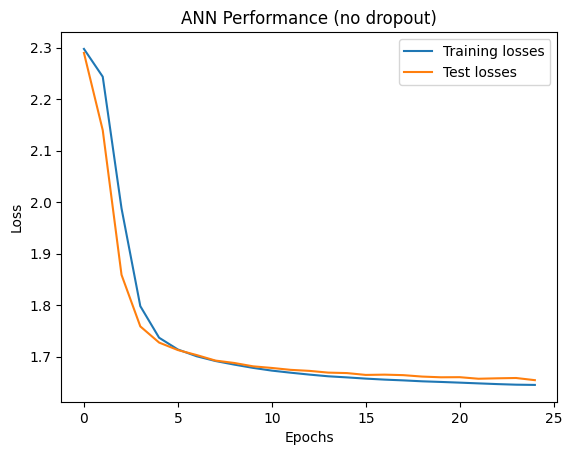

In [11]:
plt.plot(ann_hist, label=["Training losses","Test losses"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Performance (no dropout)")
plt.legend()
plt.show()

In [44]:
def ConfM(dataloader, model):
    '''
    Create a confusion matrix
    '''
    predictions = []
    labels = []
    for data, label in dataloader:
        pred = model(data)
        pred = pred.argmax(1)
        predictions+=pred.tolist()
        labels+=label.tolist()
    cm = confusion_matrix(labels,predictions)
    return cm

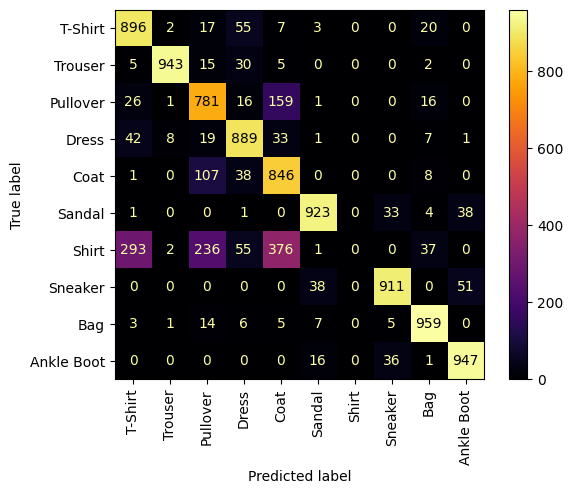

In [45]:
ann_cm = ConfM(test_loader,ann_model)
ConfusionMatrixDisplay(ann_cm, display_labels=data_labels).plot(xticks_rotation='vertical',cmap = 'inferno')

In [14]:
ann_dropout = MultilayerPerceptron(1024,512,256,use_dropout=True)
print(ann_dropout)
dropout_optimizer = torch.optim.SGD(ann_dropout.parameters(), lr=learn_rate, momentum=0.9)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [15]:
dropout_hist, dropout_accuracy = run(train_loader,test_loader,ann_dropout,epochs,loss_fn,dropout_optimizer)

Epoch 1/25
Training loss = 2.298030
Test loss = 2.288647 (Accuracy = 31.08%)
Epoch 2/25
Training loss = 2.241359
Test loss = 2.165352 (Accuracy = 25.04%)
Epoch 3/25
Training loss = 2.070880
Test loss = 1.921892 (Accuracy = 62.88%)
Epoch 4/25
Training loss = 1.863700
Test loss = 1.792616 (Accuracy = 69.37%)
Epoch 5/25
Training loss = 1.780364
Test loss = 1.744088 (Accuracy = 73.98%)
Epoch 6/25
Training loss = 1.742457
Test loss = 1.721290 (Accuracy = 75.38%)
Epoch 7/25
Training loss = 1.722698
Test loss = 1.709545 (Accuracy = 76.12%)
Epoch 8/25
Training loss = 1.710977
Test loss = 1.699708 (Accuracy = 76.86%)
Epoch 9/25
Training loss = 1.701816
Test loss = 1.694193 (Accuracy = 77.44%)
Epoch 10/25
Training loss = 1.695090
Test loss = 1.687959 (Accuracy = 77.79%)
Epoch 11/25
Training loss = 1.689813
Test loss = 1.684724 (Accuracy = 78.26%)
Epoch 12/25
Training loss = 1.685051
Test loss = 1.680406 (Accuracy = 78.57%)
Epoch 13/25
Training loss = 1.680905
Test loss = 1.678738 (Accuracy = 78.

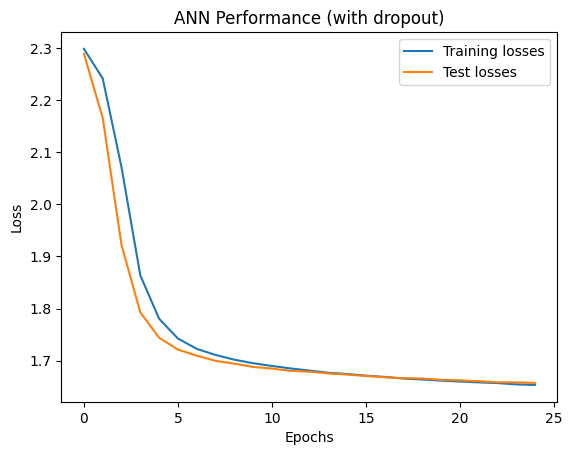

In [16]:
plt.plot(dropout_hist, label=["Training losses","Test losses"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Performance (with dropout)")
plt.legend()
plt.show()

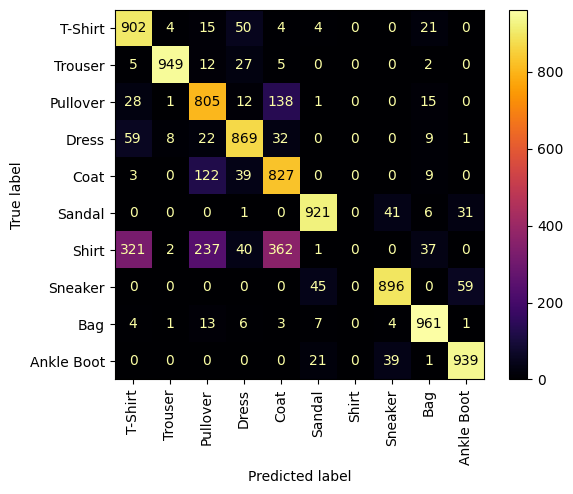

In [26]:
dropout_cm = ConfM(test_loader,ann_dropout)
ConfusionMatrixDisplay(dropout_cm, display_labels=data_labels).plot(xticks_rotation='vertical', cmap = 'inferno')